In [1]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.8.2
Running on TPU  ['10.61.209.218:8470']


In [2]:
import math
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Temperature data

In [3]:
#DUBLIN. /content/drive/MyDrive/Energy_Project
df_dublin = pd.read_csv('/content/drive/MyDrive/Energy_Project/532_dublin_airport.csv')
df_dublin.date = pd.to_datetime(df_dublin.date, infer_datetime_format=True, errors='ignore')
# fix space value
df_dublin.wdsp.replace(to_replace= ' ', value=0, inplace=True)
df_dublin.wdsp = df_dublin.wdsp.astype('int32')
dff_dublin = df_dublin.drop(columns=['Unnamed: 0', 'ind', 'rain', 'ind.1', 'ind.2', 'wetb', 'dewpt', 'ind.3', 'ind.4', 'ww', 'w', 'sun', 'vis', 'clht', 'clamt'])
dff_dublin['wddir'] = dff_dublin['wddir'].bfill()

In [4]:
#CORK
df_cork = pd.read_csv('/content/drive/MyDrive/Energy_Project/3904_cork_airport.csv')
df_cork.date = pd.to_datetime(df_cork.date, infer_datetime_format=True, errors='ignore')
# fix space value
df_cork.wdsp.replace(to_replace= ' ', value=0, inplace=True)
df_cork.wdsp = df_cork.wdsp.astype('int32')
dff_cork = df_cork.drop(columns=['Unnamed: 0', 'ind', 'rain', 'ind.1', 'ind.2', 'wetb', 'dewpt', 'ind.3', 'ind.4', 'ww', 'w', 'sun', 'vis', 'clht', 'clamt'])
dff_cork['wddir'] = dff_cork['wddir'].bfill()

In [5]:
#SHANNON
df_shannon = pd.read_csv('/content/drive/MyDrive/Energy_Project/518_shannon_airport.csv')
df_shannon.date = pd.to_datetime(df_shannon.date, infer_datetime_format=True, errors='ignore')
# fix space value
df_shannon.wdsp.replace(to_replace= ' ', value=0, inplace=True)
df_shannon.wdsp = df_shannon.wdsp.astype('int32')
dff_shannon = df_shannon.drop(columns=['Unnamed: 0', 'ind', 'rain', 'ind.1', 'ind.2', 'wetb', 'dewpt', 'ind.3', 'ind.4', 'ww', 'w', 'sun', 'vis', 'clht', 'clamt'])
dff_shannon['wddir'] = dff_shannon['wddir'].bfill()

In [6]:
#BELMULLET
df_bel = pd.read_csv('/content/drive/MyDrive/Energy_Project/2375_belmullet.csv')
df_bel.date = pd.to_datetime(df_bel.date, infer_datetime_format=True, errors='ignore')
# fix space value
df_bel.wdsp.replace(to_replace= ' ', value=0, inplace=True)
df_bel.wdsp = df_bel.wdsp.astype('int32')
dff_bel = df_bel.drop(columns=['Unnamed: 0', 'ind', 'rain', 'ind.1', 'ind.2', 'wetb', 'dewpt', 'ind.3', 'ind.4', 'ww', 'w', 'sun', 'vis', 'clht', 'clamt'])
dff_bel['wddir'] = dff_bel['wddir'].bfill()

In [7]:
#MALIN HEAD
df_malin = pd.read_csv('/content/drive/MyDrive/Energy_Project/1575_malin_head.csv')
df_malin.date = pd.to_datetime(df_malin.date, infer_datetime_format=True, errors='ignore')
# fix space value
df_malin.wdsp.replace(to_replace= ' ', value=0, inplace=True)
df_malin.wdsp = df_malin.wdsp.astype('int32')
dff_malin = df_malin.drop(columns=['Unnamed: 0', 'ind', 'rain', 'ind.1', 'ind.2', 'wetb', 'dewpt', 'ind.3', 'ind.4', 'ww', 'w', 'sun', 'vis', 'clht', 'clamt'])
dff_malin['wddir'] = dff_malin['wddir'].bfill()

In [8]:
#Merging weather data from different locations into a single dataset
left = dff_bel.set_index(['date']).copy()
right = dff_dublin.set_index(['date'])

weather_df = left.join(right, lsuffix="_BEL", rsuffix="_DUB")

right = dff_shannon.set_index(['date'])
weather_df = weather_df.join(right, lsuffix="", rsuffix="_SHA") #ask

right = dff_cork.set_index(['date'])
weather_df = weather_df.join(right, lsuffix="", rsuffix="_COR")

right = dff_malin.set_index(['date'])
weather_df = weather_df.join(right, lsuffix="", rsuffix="_MAL")

weather_df = weather_df.reset_index()

weather_df.columns

Index(['date', 'temp_BEL', 'vappr_BEL', 'rhum_BEL', 'msl_BEL', 'wdsp_BEL',
       'wddir_BEL', 'temp_DUB', 'vappr_DUB', 'rhum_DUB', 'msl_DUB', 'wdsp_DUB',
       'wddir_DUB', 'temp', 'vappr', 'rhum', 'msl', 'wdsp', 'wddir',
       'temp_COR', 'vappr_COR', 'rhum_COR', 'msl_COR', 'wdsp_COR', 'wddir_COR',
       'temp_MAL', 'vappr_MAL', 'rhum_MAL', 'msl_MAL', 'wdsp_MAL',
       'wddir_MAL'],
      dtype='object')

# Energy Data

In [9]:
weather_df['date'] = pd.to_datetime(weather_df['date'], infer_datetime_format=True)
weather_resampled = weather_df.set_index('date')
weather_daily = weather_resampled.resample('D').mean()

In [10]:
df1 = pd.read_csv('/content/drive/MyDrive/Energy_Project/Energy Production_clean.csv')
df1 = df1.drop(columns=['Start Time', 'Fossil Gas  - Actual Aggregated [MW]', 'Fossil Hard coal  - Actual Aggregated [MW]', 'Fossil Oil  - Actual Aggregated [MW]', 'Fossil Peat  - Actual Aggregated [MW]', 'Hydro Pumped Storage  - Actual Aggregated [MW]', 'Hydro Pumped Storage  - Actual Consumption [MW]', 'Hydro Run-of-river and poundage  - Actual Aggregated [MW]', 'Other  - Actual Aggregated [MW]'])
print(df1.shape)
df1 = df1.rename(columns = {'End Time':'date'})

(122750, 3)


In [11]:
df1['date'] = pd.to_datetime(df1['date'], infer_datetime_format=True)
df1 = df1.set_index('date')
#Filling missing values with Linear Interpolation
df1['Wind Onshore  - Actual Aggregated [MW]'] = df1['Wind Onshore  - Actual Aggregated [MW]'].interpolate(method='linear', limit_direction='forward', axis=0)


In [12]:
#Converting half hourly data to hourly data
df1_hourly = df1.resample('1H').sum()

In [13]:
#Breaking date into month, day, week, weekday
weather_df['year'] = pd.to_datetime(weather_df['date']).dt.month
weather_df['month'] = pd.to_datetime(weather_df['date']).dt.month
weather_df['day'] = pd.to_datetime(weather_df['date']).dt.day
weather_df['week_number'] = pd.to_datetime(weather_df['date']).dt.week
weather_df['week_day'] = pd.to_datetime(weather_df['date']).dt.weekday
weather_df['isweekday'] = weather_df['week_day'] < 5
weather_df['hour'] = pd.to_datetime(weather_df['date']).dt.hour

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


In [14]:
df2 = pd.read_csv('/content/drive/MyDrive/Energy_Project/Energy_Total_Load_Day-Ahead_Ireland_2015-22.csv')
print(df2.shape)
df2.head()

(122750, 4)


,Time_Start,Time_End,Day-ahead Total Load Forecast [MW] - Ireland (IE),Actual Total Load [MW] - Ireland (IE)
0,01.01.2015 00:00,01.01.2015 00:30,NaN,NaN
1,01.01.2015 00:30,01.01.2015 01:00,NaN,NaN
2,01.01.2015 01:00,01.01.2015 01:30,3616.0,2903.0
3,01.01.2015 01:30,01.01.2015 02:00,3550.0,2832.0
4,01.01.2015 02:00,01.01.2015 02:30,3403.0,2726.0


In [15]:
df2['Time_End'] = pd.to_datetime(df2['Time_End'])
df2 = df2.drop(columns='Time_Start')
df2 = df2.set_index('Time_End')

In [16]:
df2['Actual Total Load [MW] - Ireland (IE)'] = df2['Actual Total Load [MW] - Ireland (IE)'].interpolate(method='linear', limit_direction='forward', axis=0)

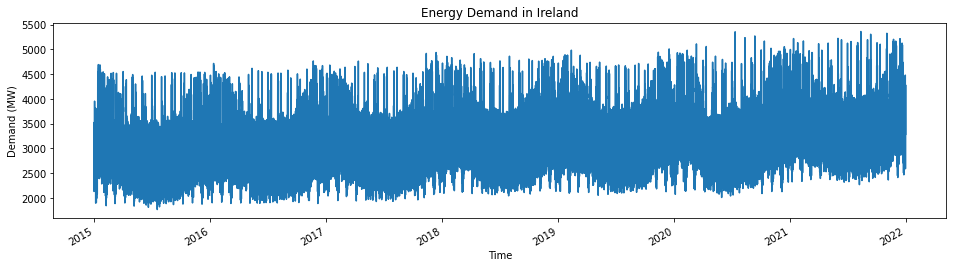

In [17]:
df2['Actual Total Load [MW] - Ireland (IE)'].plot(figsize=(16,4),legend=False)

plt.title('Energy Demand in Ireland')
plt.xlabel('Time')
plt.ylabel('Demand (MW)')

plt.show()

In [18]:
energy_total = pd.read_csv('/content/drive/MyDrive/Energy_Project/Energy_Total_Load_Day-Ahead_Ireland_2015-22.csv')
energy_total = energy_total[['Time_Start', 
                             'Day-ahead Total Load Forecast [MW] - Ireland (IE)', 
                             'Actual Total Load [MW] - Ireland (IE)']]
energy_total.columns = ['date', 'ForecastDemandMW', 'ActualDemandMW']
energy_total['date'] = pd.to_datetime(energy_total['date'], infer_datetime_format=True)
energy_total = energy_total.set_index('date')
energy_total_hourly = energy_total.resample('1H').mean()

In [19]:
df1_hourly.columns = ['ActualWindMW']
df1_hourly.head()

,ActualWindMW
date,
2015-01-01 00:00:00,0.0
2015-01-01 01:00:00,1287.0
2015-01-01 02:00:00,2626.0
2015-01-01 03:00:00,2535.0
2015-01-01 04:00:00,2381.0


In [20]:
weather_load = weather_df.merge(energy_total_hourly,on='date')
weather_energy =  weather_load.merge(df1_hourly,on='date')
weather_energy.columns

Index(['date', 'temp_BEL', 'vappr_BEL', 'rhum_BEL', 'msl_BEL', 'wdsp_BEL',
       'wddir_BEL', 'temp_DUB', 'vappr_DUB', 'rhum_DUB', 'msl_DUB', 'wdsp_DUB',
       'wddir_DUB', 'temp', 'vappr', 'rhum', 'msl', 'wdsp', 'wddir',
       'temp_COR', 'vappr_COR', 'rhum_COR', 'msl_COR', 'wdsp_COR', 'wddir_COR',
       'temp_MAL', 'vappr_MAL', 'rhum_MAL', 'msl_MAL', 'wdsp_MAL', 'wddir_MAL',
       'year', 'month', 'day', 'week_number', 'week_day', 'isweekday', 'hour',
       'ForecastDemandMW', 'ActualDemandMW', 'ActualWindMW'],
      dtype='object')

# Final Data creation

In [21]:
weather_energy.set_index('date', inplace=True, drop=False)
display(weather_energy.head())

,date,temp_BEL,vappr_BEL,rhum_BEL,msl_BEL,wdsp_BEL,wddir_BEL,temp_DUB,vappr_DUB,rhum_DUB,...,year,month,day,week_number,week_day,isweekday,hour,ForecastDemandMW,ActualDemandMW,ActualWindMW
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,2015-01-01 00:00:00,11.2,11.1,84,1015.0,28,200,9.2,10.2,88,...,1,1,1,1,3,True,0,NaN,NaN,0.0
2015-01-01 01:00:00,2015-01-01 01:00:00,11.3,11.5,86,1014.8,27,200,9.2,9.3,80,...,1,1,1,1,3,True,1,3583.0,2867.5,1287.0
2015-01-01 02:00:00,2015-01-01 02:00:00,11.4,11.7,86,1014.8,26,200,9.2,9.2,79,...,1,1,1,1,3,True,2,3332.5,2678.0,2626.0
2015-01-01 03:00:00,2015-01-01 03:00:00,11.2,11.8,88,1013.6,25,200,10.1,8.7,71,...,1,1,1,1,3,True,3,3047.5,2432.5,2535.0
2015-01-01 04:00:00,2015-01-01 04:00:00,10.3,11.8,94,1012.1,20,180,10.6,9.3,72,...,1,1,1,1,3,True,4,2830.0,2276.0,2381.0


# Data Engineering

In [22]:
suffixes = ['_COR', '_DUB', '_BEL', '', '_MAL']
for suffix in suffixes:
  weather_energy['wind' + suffix + '_sin'] = weather_energy['wdsp'+ suffix] * weather_energy['wddir' + suffix].apply(math.sin)
  weather_energy['wind' + suffix + '_cos'] = weather_energy['wdsp'+ suffix] * weather_energy['wddir' + suffix].apply(math.cos)

weather_energy.columns

Index(['date', 'temp_BEL', 'vappr_BEL', 'rhum_BEL', 'msl_BEL', 'wdsp_BEL',
       'wddir_BEL', 'temp_DUB', 'vappr_DUB', 'rhum_DUB', 'msl_DUB', 'wdsp_DUB',
       'wddir_DUB', 'temp', 'vappr', 'rhum', 'msl', 'wdsp', 'wddir',
       'temp_COR', 'vappr_COR', 'rhum_COR', 'msl_COR', 'wdsp_COR', 'wddir_COR',
       'temp_MAL', 'vappr_MAL', 'rhum_MAL', 'msl_MAL', 'wdsp_MAL', 'wddir_MAL',
       'year', 'month', 'day', 'week_number', 'week_day', 'isweekday', 'hour',
       'ForecastDemandMW', 'ActualDemandMW', 'ActualWindMW', 'wind_COR_sin',
       'wind_COR_cos', 'wind_DUB_sin', 'wind_DUB_cos', 'wind_BEL_sin',
       'wind_BEL_cos', 'wind_sin', 'wind_cos', 'wind_MAL_sin', 'wind_MAL_cos'],
      dtype='object')

In [23]:
def transformTimeInto2d(df):
  df['Day_inYear'] = None
  df['daysInYear'] = None
  df['radianTime'] = None
  df['radianTimeCos'] = None
  df['radianTimeSin'] = None
  df['hourCos'] = None
  df['hourSin'] = None

  def check_leap(year):
    if year%4 == 0:
      return 366
    else:
      return 365

  def transformTimeInto2dRow(row):
    row['Day_inYear'] = row['date'].timetuple().tm_yday
    daysInYear = check_leap(row['year'])
    row['daysInYear'] = daysInYear
    row['radianTime'] = (row.hour + row.Day_inYear * 24 ) / (24 * daysInYear) * (2*np.pi)
    row['radianTimeCos'] = math.cos(row['radianTime'])
    row['radianTimeSin'] = math.sin(row['radianTime'])
    row['hourCos'] = math.cos(row.hour/24 * (2*np.pi))
    row['hourSin'] = math.sin(row.hour/24 * (2*np.pi))
    return row

  df = df.apply(transformTimeInto2dRow, axis='columns')
  return df

weather_energy_2d_Data = transformTimeInto2d(weather_energy)
weather_energy_2d_Data.columns

Index(['date', 'temp_BEL', 'vappr_BEL', 'rhum_BEL', 'msl_BEL', 'wdsp_BEL',
       'wddir_BEL', 'temp_DUB', 'vappr_DUB', 'rhum_DUB', 'msl_DUB', 'wdsp_DUB',
       'wddir_DUB', 'temp', 'vappr', 'rhum', 'msl', 'wdsp', 'wddir',
       'temp_COR', 'vappr_COR', 'rhum_COR', 'msl_COR', 'wdsp_COR', 'wddir_COR',
       'temp_MAL', 'vappr_MAL', 'rhum_MAL', 'msl_MAL', 'wdsp_MAL', 'wddir_MAL',
       'year', 'month', 'day', 'week_number', 'week_day', 'isweekday', 'hour',
       'ForecastDemandMW', 'ActualDemandMW', 'ActualWindMW', 'wind_COR_sin',
       'wind_COR_cos', 'wind_DUB_sin', 'wind_DUB_cos', 'wind_BEL_sin',
       'wind_BEL_cos', 'wind_sin', 'wind_cos', 'wind_MAL_sin', 'wind_MAL_cos',
       'Day_inYear', 'daysInYear', 'radianTime', 'radianTimeCos',
       'radianTimeSin', 'hourCos', 'hourSin'],
      dtype='object')

In [24]:
weather_energy_2d_Data['ActualDemandMW_shift'] = weather_energy_2d_Data['ActualDemandMW'].shift(24)
weather_energy_2d_Data['ForecastDemandMW_shift'] = weather_energy_2d_Data['ForecastDemandMW'].shift(24)
weather_energy_2d_Data.dropna(inplace=True)

In [25]:
# attrs = ['date', 'hour', 'month', 'year', 'Day_inYear',
#           'wdsp_BEL', 'wddir_BEL', 'wind_BEL_sin', 'wind_BEL_cos','vappr_BEL', 'rhum_BEL', 'temp_BEL',
#           'wdsp', 'wddir', 'wind_sin', 'wind_cos', 'vappr', 'rhum', 'temp', 'msl',
#           'wdsp_COR', 'wddir_COR', 'wind_COR_sin', 'wind_COR_cos', 'vappr_COR', 'rhum_COR', 'temp_COR',
#           'wdsp_DUB', 'wddir_DUB', 'wind_DUB_sin', 'wind_DUB_cos', 'vappr_DUB', 'rhum_DUB', 'temp_DUB',
#           'wdsp_MAL', 'wddir_MAL', 'wind_MAL_sin', 'wind_MAL_cos', 'vappr_MAL', 'rhum_MAL', 'temp_MAL',
#           'radianTimeSin', 'radianTimeCos', 'hourSin', 'hourCos',
#           'ActualWindMW', 'ActualDemandMW', 'ForecastDemandMW']

feature_attr = ['wind_BEL_sin', 'wind_BEL_cos','vappr_BEL', 'rhum_BEL', 'temp_BEL',
            'wind_sin', 'wind_cos', 'vappr', 'rhum', 'temp', 'msl',
            'wind_COR_sin', 'wind_COR_cos', 'vappr_COR', 'rhum_COR', 'temp_COR',
            'wind_DUB_sin', 'wind_DUB_cos', 'vappr_DUB', 'rhum_DUB', 'temp_DUB',
            'wind_MAL_sin', 'wind_MAL_cos', 'vappr_MAL', 'rhum_MAL', 'temp_MAL',
          'radianTimeSin', 'radianTimeCos', 'hourSin', 'hourCos', 'ActualDemandMW_shift', 'ForecastDemandMW_shift']
target_attr = ['ActualWindMW']

In [26]:
final_dataset = weather_energy_2d_Data[(feature_attr + target_attr)]
final_dataset.shape

(59112, 33)

In [27]:
final_dataset.index.max()

Timestamp('2021-12-31 23:00:00')

In [28]:
train_dataset = final_dataset.iloc[final_dataset.index < '2021-12-01']
test_dataset = final_dataset.iloc[final_dataset.index > '2021-12-01']
print(train_dataset.shape)
print(test_dataset.shape)

(58499, 33)
(612, 33)


In [29]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
      a = dataset.iloc[i:(i + look_back), :-1]
      dataX.append(a)
      dataY.append(dataset.iloc[i + look_back, -1])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [30]:
trainx, trainY = create_dataset(train_dataset, 8)
testx, testY = create_dataset(test_dataset, 8)
print(trainx.shape)
print(trainY.shape)
print(testx.shape)
print(testY.shape)

58491
604
(58491, 8, 32)
(58491,)
(604, 8, 32)
(604,)


In [31]:
# trainX = np.reshape(trainx, (trainx.shape[0], 1, trainx.shape[1]))
# testX = np.reshape(testx, (testx.shape[0], 1, testx.shape[1]))

ValueError: ignored

In [32]:
model = Sequential()
model.add(LSTM(100, input_shape=(8, 32)))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=0, shuffle=False)

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 53,301
Trainable params: 53,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(trainx, trainY, epochs=300, batch_size=100, validation_data=(testx, testY), verbose=1, shuffle=False)

In [ ]:
history

In [ ]:
model.save('LSTM_Model')